In [1]:
import os
import random

In [2]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
from scipy.linalg import sqrtm

In [3]:
import pandas as pd

In [4]:
import torch

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
seed = 9999
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

\begin{align}
\alpha_t\equiv 0, \quad c_t\equiv c, g_t\equiv g, \quad dY_t = c Y_t dt + g d W_t, \quad \tau_t = \exp\big(\int_0^t c_s ds\big)=\exp(c t)
\end{align}

In [7]:
batch_size = 256

### Read flow trajectory from Variational Schrodinger diffusion models (VSDM)

In [8]:
def get_sub_sample_index(full_data, batch_size=500):
    full_data_size = full_data.shape[0]
    return np.random.choice(full_data_size, batch_size, replace=False)

### Read VSDM trajectory (full matrix)

In [9]:
path_vsdm = np.load('./results/gaussian_vsdm_4/stage20-backward-ode.npy')

path_vsdm.shape # num samples x time steps x axes
batch_sample_idx = get_sub_sample_index(path_vsdm, batch_size=batch_size)
batch_path_vsdm = path_vsdm[batch_sample_idx, :, :]

batch_path_vsdm = np.swapaxes(batch_path_vsdm, 0, 1) # time steps x num samples x axes

In [10]:
def plot_contour_and_scatter(batch_samples, full_samples, color='b', label='label'):
    full_samples = pd.DataFrame(full_samples).rename(columns={0: "X", 1: "Y"})
    sns.kdeplot(data=full_samples, x="X", y="Y", alpha=0.4)
    plt.scatter(batch_samples[:, 0], batch_samples[:, 1], marker='o', color=color, s=3, label=label)
    
def plot_traj_2d(sample_path, mu_samples, pred_nu_samples, title):
    plt.figure(figsize=(5, 3))
    plot_contour_and_scatter(sample_path[0, :, :], mu_samples, color='b', label='data')
    plt.plot(sample_path[:, :, 0], sample_path[:, :, 1], alpha=0.2, color='grey')
    plot_contour_and_scatter(sample_path[-1, :, :], pred_nu_samples, color='r', label='prior')
    plt.title(title, fontsize=18)
    plt.legend()
    plt.xlabel('X', fontsize=16)
    plt.ylabel('Y', fontsize=16)
    plt.xlim([-12, 4])
    plt.ylim([-5, 9])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.savefig(f"./figures/{title.replace(' ', '_')}.pdf", dpi=100, bbox_inches='tight')
    plt.show()

### Gaussian Schrodinger bridge: Specify mean and covariance of the two marginals

In [11]:
mu_0 = path_vsdm[:, 0, :].mean(axis=0)
Sigma_0 = np.array([[1., 1.],
                        [1., 5.]])

mu_1 = path_vsdm[:, -1, :].mean(axis=0)
Sigma_1 = np.array([[0.5453, 0.003],
                    [0.003, 0.8211]])

c = -2 ## c in Eq(7) of [2] corresponds to setting beta-max=4 Eq(25) in [1]
g = np.sqrt(-2*c) # VPSDE

# [1] Song: https://arxiv.org/pdf/2011.13456.pdf
# [2] Bunne: https://arxiv.org/pdf/2202.05722.pdf

In [12]:
class StaticSchrodingerBridge:
    def __init__(self, c: float, g: float, \
                       mu_0: np.ndarray, mu_1: np.ndarray, \
                       Sigma_0: np.ndarray, Sigma_1: np.ndarray):
        self.c = c
        self.g = g
        self.zeta = 0 # since alpha_s=0 in Eq.(25)
        self.mu_0 = mu_0
        self.mu_1 = mu_1
        self.Sigma_0 = Sigma_0
        self.Sigma_1 = Sigma_1
    
    @property
    def sigma_star(self):
        return np.sqrt(self.kappa(1., 1.) / self.tau(1.))
    
    @property
    def D(self) -> np.ndarray:
        return sqrtm(4*sqrtm(self.Sigma_0)@self.Sigma_1@sqrtm(self.Sigma_0) + self.sigma_star**4*np.eye(2))
    
    @property
    def C(self) -> np.ndarray:
        return 0.5 * (sqrtm(self.Sigma_0)@self.D@np.linalg.inv(sqrtm(self.Sigma_0)) - self.sigma_star**2*np.eye(2))
    
    def tau(self, t: float) -> float:
        return np.exp(self.c * t)
    
    def xi(self, t: float) -> float:
        return self.g**2 * (1 - np.exp(-2.*self.c*t)) / 2. / self.c
    
    def kappa(self, t: float, t_prime: float) -> float:
        return self.tau(t) * self.tau(t_prime) * self.xi(t)
    
    def r(self, t: float) -> float:
        return self.kappa(t, 1.) / self.kappa(1., 1.)
    
    def r_bar(self, t: float) -> float:
        return self.tau(t) - self.r(t) * self.tau(1.)
    
    def rho(self, t: float) -> float:
        return self.xi(t) / self.xi(1.)

In [13]:
class DynSchrodingerBridge(StaticSchrodingerBridge):
    def __init__(self, c: float, g: float, \
                       mu_0: np.ndarray, mu_1: np.ndarray, \
                       Sigma_0: np.ndarray, Sigma_1: np.ndarray):
        StaticSchrodingerBridge.__init__(self, c, g, mu_0, mu_1, Sigma_0, Sigma_1)
        
    def P(self, t: float) -> np.ndarray:
        return grad(self.r)(t) * (self.r(t) * self.Sigma_1 + self.r_bar(t) * self.C)
    
    def Q(self, t: float) -> np.ndarray:
        return -grad(self.r_bar)(t) * (self.r_bar(t) * self.Sigma_0 + self.r(t) * self.C)
    
    def S(self, t: float) -> np.ndarray:
        scaled_I = (self.c * self.kappa(t, t) * (1 - self.rho(t)) - self.g**2 * self.rho(t)) * np.eye(2)
        return self.P(t) - self.Q(t).transpose() + scaled_I
    
    def mu(self, t: float) -> np.ndarray:
        return (self.r_bar(t) * self.mu_0 + self.r(t) * self.mu_1).reshape(-1, 1)
    
    def grad_mu(self, t: float) -> torch.Tensor:
        return (grad(self.r_bar)(t) * self.mu_0 + grad(self.r)(t) * self.mu_1).reshape(-1, 1)
    
    def Sigma(self, t: float) -> np.ndarray:
        return self.Sigma_0*self.r_bar(t)**2 + self.Sigma_1*self.r(t)**2 \
                + self.r(t)*self.r_bar(t)*(self.C + self.C.transpose()) \
                + self.kappa(t, t)*(1 - self.rho(t))*np.eye(2)
    
    def f_N(self, t: float, x: np.ndarray) -> np.ndarray:
        mat_mul_mat = self.S(t).transpose() @ np.linalg.inv(self.Sigma(t)) 
        return (mat_mul_mat @ (x.transpose() - self.mu(t)) + self.grad_mu(t)).transpose()
            
    def flow_propagate(self, x: np.ndarray, steps=100) -> np.ndarray:
        stepsize = 1. / steps
        self.Xs = np.array([x])
        for i in range(steps):
            # dx = (f-0.5*g^2 * grad log p_t)dt
            scores = (-np.linalg.inv(self.Sigma(i/steps)) @ (x.transpose() - self.mu(i/steps))).transpose()
            x = x + stepsize * (self.f_N(i/steps, x) - 0.5 * self.g**2 * scores)
            self.Xs = np.append(self.Xs, [x], axis=0)

In [14]:
batch_path_vsdm.shape

(100, 256, 2)

In [15]:
DynSB = DynSchrodingerBridge(c, g, mu_0, mu_1, Sigma_0, Sigma_1)

### Simulate a large number of samples to plot contour of density

In [16]:
mu_samples = np.random.multivariate_normal(mu_0, Sigma_0, (3000,))
mu_samples.shape

(3000, 2)

In [17]:
#mu_samples = np.random.multivariate_normal(mu_0, Sigma_0, (3000,))
mu_samples = batch_path_vsdm[0, :, :]
mu_samples.shape

(256, 2)

In [18]:
sub_sample_idx = get_sub_sample_index(mu_samples, batch_size=batch_size)
batch_mu_samples = mu_samples[sub_sample_idx, :]

DynSB.flow_propagate(batch_mu_samples)
nu_samples = DynSB.Xs[-1, :, :]

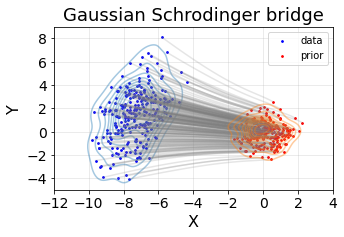

In [19]:
plot_traj_2d(DynSB.Xs, mu_samples, nu_samples, title='Gaussian Schrodinger bridge')

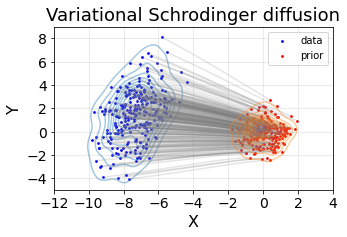

In [20]:
plot_traj_2d(batch_path_vsdm, mu_samples, batch_path_vsdm[-1, :, :], title='Variational Schrodinger diffusion')